In [1]:
import torch
import torch.backends.cudnn as cudnn
import cfl
from datapreptest import *
from utils import *
from models import *
from sklearn.metrics import confusion_matrix
import natsort
import matplotlib.pyplot as plt
from models import *
from models.unet import *
#from .unet_model import UNet
from models.UnetPlusPlus import NestedUNet
from models.unet_model import uNet
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
file_test = '/home/jay/Documents/courses/Aicourse/Brats/test/'
cudnn.benchmark = True
testdataload = data_load(file_test,batch_size=1, datatype='Test')

cuda:0


In [5]:
layer_multipler = 22
n_layers = 4
#lr = 0.0388
drop_rate = 0

net = UNet(4,4, layer_multipler= layer_multipler, n_layers=n_layers, useBN=True,
                   drop_rate=0)
#net = uNet(4,4, layer_multipler= layer_multipler, n_layers=n_layers,
#                   drop_rate=drop_rate,bilinear=True)

#net= NestedUNet(num_classes= 4, input_channels=4,layer_multipler= layer_multipler, n_layers=n_layers,
#                   drop_rate=drop_rate) #load_model('', mode='test')
net = net.to(device)
net.eval()
#optimizer = SGD(net.parameters(), lr=lr)

torch.set_grad_enabled(False)

[22, 44, 88, 176]


In [6]:
optimizer=None

checkpoint = Checkpoint(net, optimizer)
checkpoint.load(os.path.join('./Unet_Final/unet.pth'))
best_score = checkpoint.best_score
start_epoch = checkpoint.epoch+1

155
0.9002221418965247
File Save: /home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P3_pred
(155, 4, 240, 240)
155
0.9204183824600712
File Save: /home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P8_pred
(155, 4, 240, 240)
155
0.8388511726933141
File Save: /home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P44_pred
(155, 4, 240, 240)
155
0.8281437189348282
File Save: /home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P50_pred
(155, 4, 240, 240)
155
0.9361244109369093
File Save: /home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P73_pred
(155, 4, 240, 240)
155
0.7022777022853974
File Save: /home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P74_pred
(155, 4, 240, 240)
155
0.9190693639939831
File Save: /home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P81_pred
(155, 4, 240, 240)
1

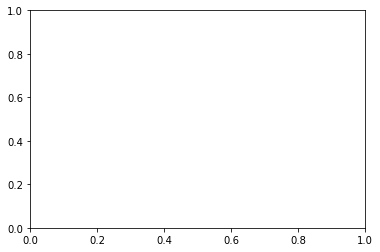

In [11]:
predication=[]
GTImages=[]
GT = []
loss=0
PDice = []
Pacc=[]
size = 0
acc=0
nbatch = len(testdataload)
n=0
for idx, (inputs, targets, paths) in enumerate(testdataload):
            #enable_dropout(net)
                inputs = inputs.to(device)
                targets = targets.to(device)
                predicationvar=[]
                GTImagesvar=[]
                GTvar = []
                
                for j in range(0,1):
                    with torch.no_grad():
                        outputs = net(inputs)
                        outputs = outputs.softmax(1)
                
            
                    # plt.subplot(1,2,1)
                    # plt.imshow(targets.cpu().detach().numpy()[0,1,:,:])
                    # plt.colorbar()
                    # plt.subplot(1,2,2)
                    # plt.imshow((outputs.cpu().detach().numpy()[0,1,:,:]))
                    # plt.colorbar()
                    
                    # plt.show()
                    predicationvar.append(outputs.cpu().detach().numpy())
                
                loss += dice_loss(outputs,targets, multiclass=True).item()
                acc += (outputs.argmax(1) == targets.argmax(1)).type(torch.float).sum().item()
                size += outputs.shape[0]*outputs.shape[2]*outputs.shape[3]
            
                # plt.subplot(1,2,1)
                # plt.imshow(targets.cpu().detach().numpy()[0,1,:,:])
                # plt.colorbar()
                # plt.subplot(1,2,2)
                # plt.imshow((outputs.cpu().detach().numpy()[0,1,:,:]))
                # plt.colorbar()
                    
                # plt.show()


                    #print(np.sum(predicationvar))
                        #GTImagesvar.append(inputs.cpu().detach().numpy())
                        #GTvar.append(targets.cpu().detach().numpy())
                
                predication.append(predicationvar)
                GTImages.append(inputs.cpu().detach().numpy())
                GT.append(targets.cpu().detach().numpy())
                
                n=n+1
                #filename_pred = f'/home/jay/Documents/course/AiCourse/code_hyperParameterTune/UnetPPtestOutput/{}'
                #np.save(filename_pred, predication)
                
                if n==155:#(((idx % (31*n)) == 0) & idx != 0):
                    print(n)
                    loss /= n
                    acc /= size
                    n=0


                    print(1-loss)
                    PDice.append(1-loss)
                    Pacc.append(acc)
                    
                    patient = paths[0].split('volume_')[1].split('_')[0]
                    filename_pred = f'./UNettestOutput_nodp/P{patient}_pred'
                    filename_GT = f'./UNettestOutput_nodp/P{patient}_GT'
                
                 #   print(f'File Save: {filename_pred}')
                    np.save(filename_pred, np.squeeze(predication))

                    np.save(filename_GT, np.squeeze(GT))
                    
                    print(f'File Save: {filename_pred}')
                    print(np.shape(np.squeeze(predication)))
                    predication=[]
                    GT= []
                    loss=0
                    size = 0
                    acc=0
                    plt.cla()
                    
                #loss += dice_loss(outputs.softmax(1),targets, multiclass=True).item()
                #acc += (outputs.argmax(1) == targets.argmax(1)).type(torch.float).sum().item()
                #size += outputs.shape[0]*outputs.shape[2]*outputs.shape[3]
                
                #log_msg = '\n'.join(['Test (%d/%d): Loss: %.5f,  Dice-Coef:  %.5f' %(idx, nbatch, loss/(idx+1), 1-(loss/(idx+1)))])
                #logging.info(log_msg)

In [2]:
testfilesUnet = natsort.natsorted(glob.glob('/home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P*_pred*'))
gttestfilesUnet = natsort.natsorted(glob.glob('/home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UNettestOutput_nodp/P*_GT*'))

testfilesUnetPP = natsort.natsorted(glob.glob('/home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UnetPPtestOutput_nodp/P*_pred*'))
gttestfilesUnetPP = natsort.natsorted(glob.glob('/home/jay/Documents/courses/Aicourse/code_hyperParameterTune/UnetPPtestOutput_nodp/P*_GT*'))


length = 15#len(testfilesUnet)
volumesUnet = np.zeros([length,155,240,240,3])
volumesUnetPP = np.zeros([length,155,240,240,3])

gtUnet = np.zeros([length,155,240,240,3])
gtUnetPP = np.zeros([length,155,240,240,3])

for i in range(length):
    v = np.squeeze(np.load(testfilesUnet[i]))
   # volumesUnet[i,:,:,:,:]= np.squeeze(v)

    g = np.load(gttestfilesUnet[i])
   # gtUnet[i,:,:,:,:]= g

    #Whole Tumor, Tumor Core, Enhancing Tumor
    v = np.transpose(v, [0,2,3,1])
    #print(np.shape(v))
    g = np.transpose(g, [0,2,3,1])
    
    WTUnet = np.sum(v[:,:,:,1:4], axis=3)
    TCUnet = np.sum(v[:,:,:,[1,3]],axis=3 )
    ETUnet =  v[:,:,:,1]

    gtWTUnet = np.sum(g[:,:,:,1:], axis=3)
    gtTCUnet = np.sum(g[:,:,:,[1,3]],axis=3 )
    gtETUnet =  g[:,:,:,1]


    volumesUnet[i,:,:,:,0]= WTUnet
    volumesUnet[i,:,:,:,1]= TCUnet
    volumesUnet[i,:,:,:,2]= ETUnet
    
    gtUnet[i,:,:,:,0]= gtWTUnet
    gtUnet[i,:,:,:,1]= gtTCUnet
    gtUnet[i,:,:,:,2]= gtETUnet
    


    

    v = np.load(testfilesUnetPP[i])
    #volumesUnetPP[i,:,:,:,:]= np.squeeze(v)

    g = np.load(gttestfilesUnetPP[i])
    #gtUnetPP[i,:,:,:,:]= g
    v = np.transpose(v, [0,2,3,1])
    g = np.transpose(g, [0,2,3,1])
    
    WTUnetPP = np.sum(v[:,:,:,1:], axis=3)
    TCUnetPP = np.sum(v[:,:,:,[1,3]],axis=3 )
    ETUnetPP =  v[:,:,:,1]

    gtWTUnetPP = np.sum(g[:,:,:,1:], axis=3)
    gtTCUnetPP = np.sum(g[:,:,:,[1,3]],axis=3 )
    gtETUnetPP =  g[:,:,:,1]


    volumesUnetPP[i,:,:,:,0]= WTUnetPP
    volumesUnetPP[i,:,:,:,1]= TCUnetPP
    volumesUnetPP[i,:,:,:,2]= ETUnetPP
    
    gtUnetPP[i,:,:,:,0]= gtWTUnetPP
    gtUnetPP[i,:,:,:,1]= gtTCUnetPP
    gtUnetPP[i,:,:,:,2]= gtETUnetPP
    #print(np.shape(volumes))
    #print(np.shape(gt))

    del gtWTUnetPP, gtTCUnetPP, gtETUnetPP, WTUnetPP, TCUnetPP, ETUnetPP, gtWTUnet, gtTCUnet, gtETUnet, WTUnet, TCUnet, ETUnet,v,g
print('Done')

Done


In [3]:
fprUnet = dict()
tprUnet = dict()
roc_aucUnet = dict()

fprUnetPP = dict()
tprUnetPP = dict()
roc_aucUnetPP = dict()

precisionUnet = dict()
recallUnet = dict()
roc_auc_precisionUnet = dict()

precisionUnetPP = dict()
recallUnetPP = dict()
roc_auc_precisionUnetPP = dict()




for i in range(3):

    predUnet = np.array(volumesUnet)[:,:,:,:,i].flatten()#np.mean(predication,axis=1)/(np.std(predication,axis=1)+1e-100)
    GTUnet = np.array(gtUnet)[:,:,:,:,i].flatten()
    fprUnet[i], tprUnet[i], the = roc_curve( GTUnet, predUnet )
    roc_aucUnet[i] = auc(fprUnet[i], tprUnet[i])

    predUnetPP = np.array(volumesUnetPP)[:,:,:,:,i].flatten()#np.mean(predication,axis=1)/(np.std(predication,axis=1)+1e-100)
    GTUnetPP = np.array(gtUnetPP)[:,:,:,:,i].flatten()
    fprUnetPP[i], tprUnetPP[i], the = roc_curve( GTUnetPP, predUnetPP )
    roc_aucUnetPP[i] = auc(fprUnetPP[i], tprUnetPP[i])

    precisionUnet[i], recallUnet[i], the = precision_recall_curve(GTUnet, predUnet)
    roc_auc_precisionUnet[i] = auc(recallUnet[i], precisionUnet[i])

    precisionUnetPP[i], recallUnetPP[i], the = precision_recall_curve(GTUnetPP, predUnetPP)
    roc_auc_precisionUnetPP[i] = auc(recallUnetPP[i], precisionUnetPP[i])

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

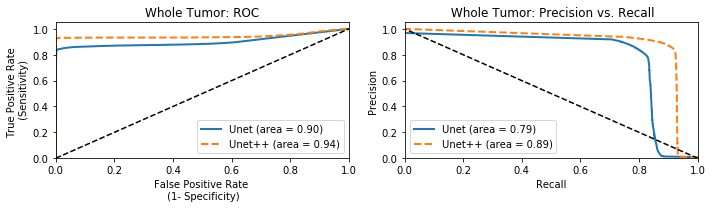

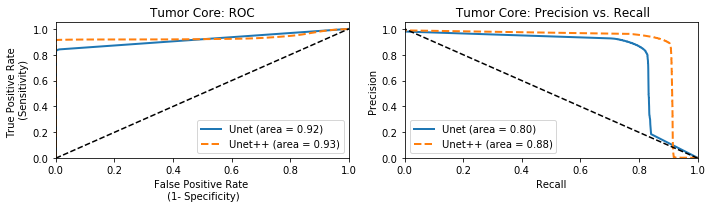

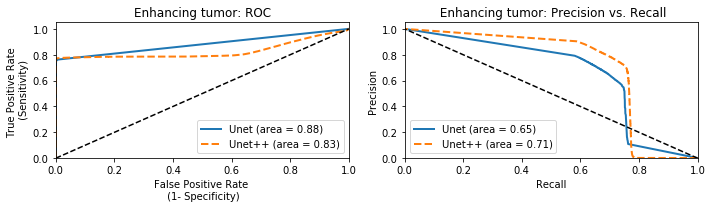

In [7]:
title = ['Whole Tumor', 'Tumor Core', 'Enhancing tumor']
label = ['Unet', 'Unet++']
plt.clf()

for i in range(3):
    
    plotNumb = [1]
#    plt.figure(figsize=[20,5])
    fig, (a1, a2) = plt.subplots(1,2, figsize=[10,3])
    
    #plt.subplot(1,2,plotNumb[i])
    a1.plot(fprUnet[i], tprUnet[i],linewidth=2, label='{0} (area = {1:0.2f})'
                                   ''.format(label[0], roc_aucUnet[i]))


    a1.plot(fprUnetPP[i], tprUnetPP[i],linewidth=2,ls='--' ,label='{0} (area = {1:0.2f})'
                                   ''.format(label[1], roc_aucUnetPP[i]))
    a1.plot([0, 1], [0, 1], 'k--')
    a1.set_xlim([0.0, 1.0])
    a1.set_ylim([0.0, 1.05])
    a1.set_xlabel('False Positive Rate \n (1- Specificity)')
    a1.set_ylabel('True Positive Rate \n (Sensitivity)')
    a1.set_title(f'{title[i]}: ROC')
    a1.legend(loc="lower right")

    #plotNumbR = [2]
    #plt.subplot(1,2,plotNumbR[i])
    a2.plot(recallUnet[i], precisionUnet[i], linewidth=2,label='{0} (area = {1:0.2f})'
                                   ''.format(label[0], roc_auc_precisionUnet[i]))


    a2.plot(recallUnetPP[i], precisionUnetPP[i], linewidth=2,ls = '--',label='{0} (area = {1:0.2f})'
                                   ''.format(label[1], roc_auc_precisionUnetPP[i]))

    a2.plot([1, 0], [0, 1], 'k--')
    a2.set_xlim([0.0, 1.0])
    a2.set_ylim([0.0, 1.05])
    a2.set_xlabel('Recall')
    a2.set_ylabel('Precision')
    a2.set_title(f' {title[i]}: Precision vs. Recall')
    a2.legend(loc="lower left")
    #lines, labels = fig.axes[-1].get_legend_handles_labels()
    
    #fig.legend(lines, labels, loc = 'upper center')
    plt.tight_layout()
    fig.savefig(f'{title[i]}.jpeg', dpi=600, format="jpeg")
    plt.show()

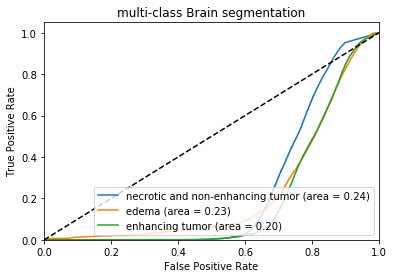

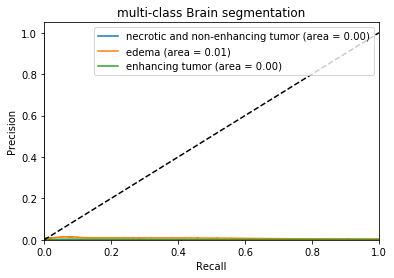

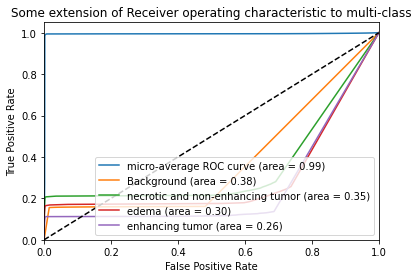